In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
from sktime.libs.vmdpy import VMD
from pymultifracs.wavelet import wavelet_analysis
from pymultifracs.mf_analysis import mfa
from pymultifracs.utils import build_q_log
from scipy.signal import welch
from sktime.transformations.series.vmd import VmdTransformer
from scipy.stats import entropy, kurtosis, skew
from scipy.signal import periodogram
import numpy as np
# Core libraries
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import seaborn as sns
from pandas import Series

# Signal processing
from scipy import signal
from scipy.signal import periodogram
from scipy.stats import entropy, kurtosis, skew
from scipy.signal import butter


# Decomposition methods
from PyEMD import EMD, EEMD, CEEMDAN
from vmdpy import VMD
import ewtpy

# Optional: your custom transformer (you must have this file)
from sktime.transformations.series.vmd import VmdTransformer
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns




In [4]:
# Load the .mat file
data = scipy.io.loadmat('../../data/data.mat')
# List keys
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'data', 'sfreq'])


In [6]:
for key in data:
    print(f"{key}: type={type(data[key])}, shape={getattr(data[key], 'shape', 'N/A')}")


__header__: type=<class 'bytes'>, shape=N/A
__version__: type=<class 'str'>, shape=N/A
__globals__: type=<class 'list'>, shape=N/A
data: type=<class 'numpy.ndarray'>, shape=(548240, 2)
sfreq: type=<class 'numpy.ndarray'>, shape=(1, 1)


In [6]:
signal = data['data']  # shape = (n_samples, n_channels)
sfreq = data.get('sfreq', 1).squeeze()  # sampling frequency, set to 1 if missing

In [7]:
print("Signal shape:", signal.shape)
print("Signal dtype:", signal.dtype)
print("Signal size in bytes:", signal.nbytes)
print("Signal size in MB:", signal.nbytes / (1024**2))


Signal shape: (548240, 2)
Signal dtype: float64
Signal size in bytes: 8771840
Signal size in MB: 8.365478515625


<function matplotlib.pyplot.show(close=None, block=None)>

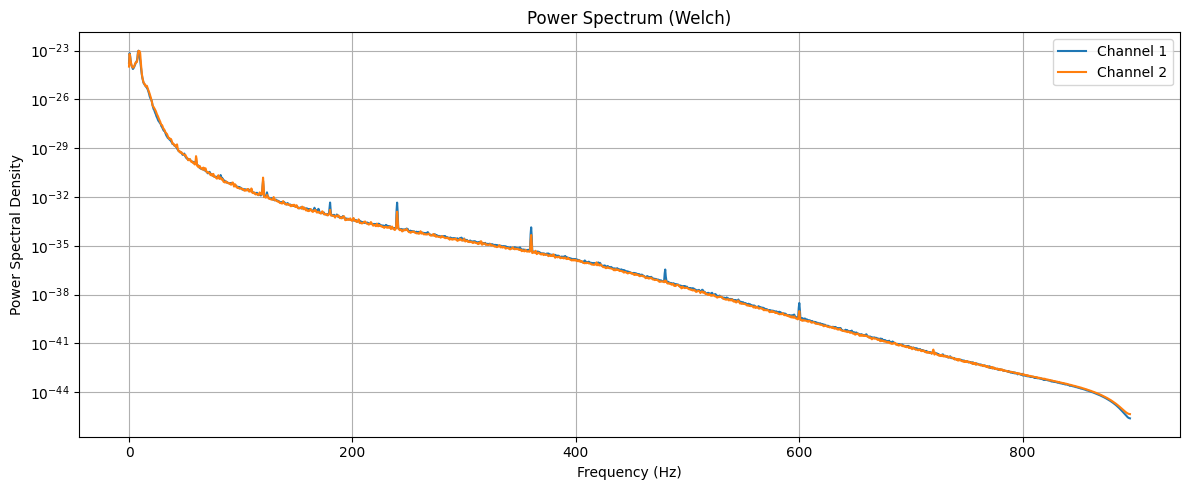

In [8]:
#sfreq = data.get('sfreq', 1).squeeze()  # sampling frequency, set to 1 if missing

# Choose window length
nperseg = int(sfreq * 2)  # 2-second segments

# Channel 1
f1, Pxx1 = welch(signal[:, 0], fs=sfreq, nperseg=nperseg)
# Channel 2
f2, Pxx2 = welch(signal[:, 1], fs=sfreq, nperseg=nperseg)

plt.figure(figsize=(12, 5))
plt.semilogy(f1, Pxx1, label='Channel 1')
plt.semilogy(f2, Pxx2, label='Channel 2')
plt.title("Power Spectrum (Welch)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show


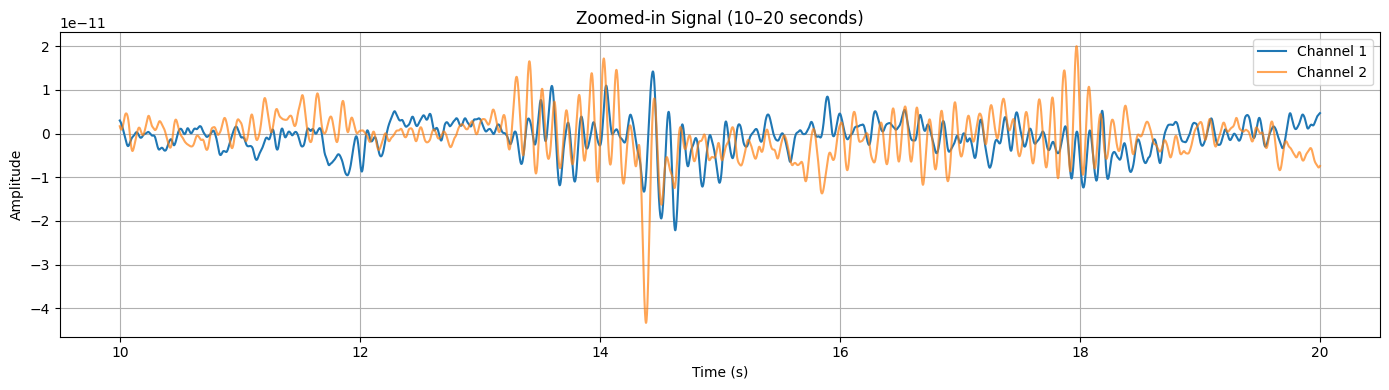

In [7]:
n_samples = signal.shape[0]
time = np.arange(n_samples) / sfreq  # time axis in seconds

zoom_start = int(10 * sfreq)
zoom_end = int(20 * sfreq)

plt.figure(figsize=(14, 4))
plt.plot(time[zoom_start:zoom_end], signal[zoom_start:zoom_end, 0], label="Channel 1")
plt.plot(time[zoom_start:zoom_end], signal[zoom_start:zoom_end, 1], label="Channel 2", alpha=0.7)
plt.title("Zoomed-in Signal (10–20 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [14]:
def extract_features_from_mode(mode, Fs):
    """Compute features from a single mode."""
    features = []
    labels = []

    mode = np.asarray(mode).flatten()
    N = len(mode)

    # AM (mean absolute value)
    AM = np.mean(np.abs(mode))
    features.append(AM)
    labels.append("AM")

    # BM (band energy)
    BM = np.sum(mode ** 2)
    features.append(BM)
    labels.append("BM")

    # Shannon entropy
    hist, bin_edges = np.histogram(mode, bins=100, density=True)
    ent_val = entropy(hist + 1e-12)
    features.append(ent_val)
    labels.append("ent")

    # Spectral features
    f, Pxx = periodogram(mode, fs=Fs)
    Pxx = np.nan_to_num(Pxx)
    f = np.nan_to_num(f)

    # Spectral centroid
    if np.sum(Pxx) > 0:
        centroid = np.sum(f * Pxx) / np.sum(Pxx)
    else:
        centroid = 0.0
    features.append(centroid)
    labels.append("Cent")

    # Spectral power
    power = np.sum(Pxx)
    features.append(power)
    labels.append("Pfreq")

    # Peak frequency
    if len(Pxx) > 0:
        peak_freq = f[np.argmax(Pxx)]
    else:
        peak_freq = 0.0
    features.append(peak_freq)
    labels.append("Ppeak")

    # Skewness
    skewness = skew(mode)
    features.append(skewness)
    labels.append("skew")

    # Kurtosis
    kurt = kurtosis(mode)
    features.append(kurt)
    labels.append("kurt")

    # Hjorth mobility
    dx = np.diff(mode)
    var_mode = np.var(mode)
    var_dx = np.var(dx)
    Hmob = np.sqrt(var_dx / var_mode) if var_mode > 0 else 0.0
    features.append(Hmob)
    labels.append("Hmob")

    # Hjorth complexity
    ddx = np.diff(dx)
    var_ddx = np.var(ddx)
    var_dx = np.var(dx)
    Hcomp = np.sqrt(var_ddx / var_dx) / Hmob if var_dx > 0 and Hmob > 0 else 0.0
    features.append(Hcomp)
    labels.append("Hcomp")

    return features, labels

def save_modes_to_disk(modes_out, base_path="saved_modes", channel_idx=0):
    os.makedirs(base_path, exist_ok=True)
    for method, modes in modes_out.items():
        method_dir = os.path.join(base_path, method)
        os.makedirs(method_dir, exist_ok=True)
        save_path = os.path.join(method_dir, f"channel_{channel_idx}_modes.npy")
        np.save(save_path, modes)

def apply_all_decompositions(signal_in, Fs, Nmodes, methods=None, return_modes=False):
    if methods is None:
        methods = ['EMD', 'EEMD', 'CEEMDAN', 'EWT', 'VMD']
    results = {}
    modes_out = {}

    for method in methods:
        try:
            start_time = time.time()  # ⏱️ Start timing

            if method == 'EMD':
                emd = EMD()
                IMFs = emd.emd(signal_in)
            elif method == 'EEMD':
                eemd = EEMD()
                eemd.trials = 100
                IMFs = eemd(signal_in, max_imf=Nmodes)
            elif method == 'CEEMDAN':
                ceemdan = CEEMDAN()
                IMFs = ceemdan(signal_in, max_imf=Nmodes)
            elif method == 'EWT':
                ewt, _, _ = ewtpy.EWT1D(signal_in, N=Nmodes)
                IMFs = ewt.T
            elif method == 'VMD':
                DC = 0
                alpha = 200
                tau = 0
                init = 1
                tol = 1e-7
                IMFs, _, _ = VMD(signal_in, alpha, tau, Nmodes, DC, init, tol) 
            elif method == 'VMDtransformer':
                vmd_transformer = VmdTransformer(K=None, kMax=7, energy_loss_coefficient=0.0001)
                IMFs = vmd_transformer.fit_transform(Series(signal_in)).to_numpy().T
                if IMFs.ndim == 1:
                    IMFs = IMFs.reshape(1, -1)

            else:
                continue
               
            exec_time = time.time() - start_time  # ⏱️ Stop timing

            modes_out[method] = IMFs

            all_feats = []
            all_labels = []

            for idx, mode in enumerate(IMFs):
                mode = np.ravel(mode)  # 🩹 Ensure 1D shape

                feats, labels = extract_features_from_mode(mode, Fs)
                all_feats.extend(feats)
                all_labels.extend([f"{label}{idx}" for label in labels])
        
            # Add execution time as a separate feature
            all_feats.append(exec_time)
            all_labels.append("decTime")
            all_feats.append(len(IMFs))
            all_labels.append("n_modes")


            results[method] = {"labels": all_labels, "values": all_feats}


        except Exception as e:
            print(f"❌ Error processing {method}: {e}")
            continue

    return (results, modes_out) if return_modes else results

In [15]:
# Load your signal
matfile = '../../data/data.mat'
data = scipy.io.loadmat(matfile)

signal_data = data['data']  # shape (n_samples, n_channels)
amplification_factor = 1e9
signal_data = data['data'] * amplification_factor
noise_level = 0.001 * np.std(signal_data)  # 1% of signal std
signal_data += np.random.normal(0, noise_level, signal_data.shape)
sfreq = float(data.get('sfreq', np.array([[1]])).squeeze())

# fs = 200  # sampling frequency
# duration = 6  # in seconds (must be >= 6s for 1024 samples at 200Hz)
# t = np.linspace(0, duration, int(fs * duration))
# x1 = np.sin(2 * np.pi * 10 * t) + 0.5 * np.sin(2 * np.pi * 30 * t)
# x2 = 0.7 * np.sin(2 * np.pi * 5 * t) + 0.3 * np.sin(2 * np.pi * 50 * t)
# signal_data = np.stack([x1, x2], axis=1)

# Parameters
Nmodes = 4  # Number of modes for all decompositions
output_dir = 'features_output'
os.makedirs(output_dir, exist_ok=True)

methods_to_use = ["EMD","VMDtransformer"]

for ch in range(signal_data.shape[1]):
    x = signal_data[:, ch]

    # Remove DC and low-pass filter
    x = x - np.mean(x)
    b, a = signal.butter(4, 40 / (0.5 * sfreq), btype='low')
    x = signal.filtfilt(b, a, x)

    # Decomposition + Feature extraction
    print(f"\n🎯 Decomposition results for channel {ch}:")
    feats_dict, modes_dict = apply_all_decompositions(x, sfreq, Nmodes, methods=methods_to_use, return_modes=True)
    print(f"\n🎯 Save modes for channel {ch}:")
    save_modes_to_disk(modes_dict, channel_idx=ch)


    for method, features in feats_dict.items():
        print(f"➡️ {method}: type={type(features)}")

        save_dir = os.path.join(output_dir, method)
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'channel_{ch}.csv')

        if isinstance(features, dict) and 'labels' in features and 'values' in features:
            header = ','.join(features['labels'])
            values = np.array([features['values']])
            np.savetxt(save_path, values, delimiter=',', fmt='%s', header=header, comments='')
        else:
            print(f"⚠️ Skipping {method} on channel {ch} due to missing 'labels' or 'values'.")

    # Plot original signal and spectrum
    signal_plot_dir = os.path.join(output_dir, 'original')
    os.makedirs(signal_plot_dir, exist_ok=True)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    t = np.linspace(0, len(x)/sfreq, len(x))
    plt.plot(t, x, color='k', linewidth=1)
    plt.title(f'Original Signal - Channel {ch}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(1, 2, 2)
    f_fft = np.fft.fft(x)
    f_fft = np.abs(f_fft[:len(f_fft)//2])
    f_freq = np.fft.fftfreq(len(x), 1/sfreq)[:len(x)//2]
    plt.plot(f_freq, f_fft, color='k', linewidth=1)
    plt.title(f'Frequency Spectrum - Channel {ch}')
    plt.xlabel('Frequency (Hz)')
    plt.tight_layout()
    plt.savefig(os.path.join(signal_plot_dir, f'channel_{ch}_original_and_spectrum.png'))
    plt.close()

    # Plot modes for selected methods
    for method in methods_to_use:
        if method in modes_dict:
            modes = modes_dict[method]
            Nmode = modes.shape[0]
            ncols = 2
            nrows = int(np.ceil(Nmode / ncols))
            plt.figure(figsize=(8, 2 * nrows))
            for i in range(Nmode):
                plt.subplot(nrows, ncols, i + 1)
                plt.plot(t, modes[i], color='k', linewidth=1)
                plt.title(f'{method} Mode {i }')
                plt.xlabel('Time (s)')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, method, f'channel_{ch}_{method}_modes.png'))
            plt.close()



🎯 Decomposition results for channel 0:

🎯 Save modes for channel 0:
➡️ EMD: type=<class 'dict'>
➡️ VMDtransformer: type=<class 'dict'>

🎯 Decomposition results for channel 1:

🎯 Save modes for channel 1:
➡️ EMD: type=<class 'dict'>
➡️ VMDtransformer: type=<class 'dict'>


In [18]:
def plot_summary_metrics(base_dir='features_output'):
    """Plot average execution time (bar) and per-channel mode count (grouped bar)."""
    all_data = []

    for method in os.listdir(base_dir):
        method_path = os.path.join(base_dir, method)
        if not os.path.isdir(method_path):
            continue

        for file in os.listdir(method_path):
            if not file.endswith('.csv'):
                continue
            try:
                channel = int(file.split('_')[1].split('.')[0])
                df = pd.read_csv(os.path.join(method_path, file))
                if 'decTime' in df.columns and 'n_modes' in df.columns:
                    all_data.append({
                        'Method': method,
                        'decTime': float(df['decTime'].values[0]),
                        'n_modes': int(df['n_modes'].values[0]),
                        'Channel': f"Ch{channel}"
                    })
            except Exception as e:
                print(f"⚠️ Skipping {file} in {method}: {e}")
                continue

    df = pd.DataFrame(all_data)
    if df.empty:
        print("❌ No execution time or mode data found.")
        return

    # Plot 1: Average execution time (bar)
    df_avg = df.groupby('Method')['decTime'].mean().reset_index()
    plt.figure(figsize=(12, 4))
    sns.barplot(data=df_avg, x='Method', y='decTime', color='skyblue')
    plt.title("Average Execution Time per Method")
    plt.xlabel("Decomposition Method")
    plt.ylabel("Execution Time (s)")
    plt.tight_layout()
    plt.show()

    # Plot 2: Number of modes per method and channel (grouped bar)
    plt.figure(figsize=(12, 5))
    sns.barplot(data=df, x='Method', y='n_modes', hue='Channel', dodge=True)
    plt.title("Number of Modes per Method and Channel")
    plt.xlabel("Decomposition Method")
    plt.ylabel("Number of Modes")
    plt.legend(title='Channel')
    plt.tight_layout()
    plt.show()

def plot_feature_distributions(base_dir='features_output', selected_features=None):
    """Plot feature distributions per mode and method."""
    if selected_features is None:
        selected_features = ['Cent', 'ent', 'Hmob', 'Hcomp']

    feature_data = []

    for method in os.listdir(base_dir):
        method_path = os.path.join(base_dir, method)
        if not os.path.isdir(method_path):
            continue

        for file in os.listdir(method_path):
            if not file.endswith('.csv'):
                continue
            try:
                df = pd.read_csv(os.path.join(method_path, file))
                for feature in selected_features:
                    for col in df.columns:
                        if col.startswith(feature):
                            mode_idx = col.replace(feature, '')
                            feature_data.append({
                                'Method': method,
                                'Channel': file.split('_')[1].split('.')[0],
                                'Mode': int(mode_idx),
                                'Feature': feature,
                                'Value': df[col].values[0]
                            })
            except Exception as e:
                print(f"⚠️ Skipping {file} in {method}: {e}")
                continue

    df_feat = pd.DataFrame(feature_data)
    if df_feat.empty:
        print("❌ No valid feature data found.")
        return

    for feature in selected_features:
        plt.figure(figsize=(10, 4))
        sns.boxplot(data=df_feat[df_feat['Feature'] == feature], x='Mode', y='Value', hue='Method')
        plt.title(f'{feature} Distribution per Mode')
        plt.xlabel('Mode Index')
        plt.ylabel(f'{feature} Value')
        plt.legend(title='Method')
        plt.tight_layout()
        plt.show()


    num_vars = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, axs = plt.subplots(1, len(method_paths_dict), figsize=(12, 6), subplot_kw=dict(polar=True))
    if len(method_paths_dict) == 1:
        axs = [axs]

    for ax, (method, paths) in zip(axs, method_paths_dict.items()):
        avg_vals_dict = compute_avg_metrics(paths, metrics, mode_index)
        avg_vals = list(avg_vals_dict.values())
        avg_vals += avg_vals[:1]  # loop back to the first

        ax.plot(angles, avg_vals, color='black', linewidth=2)
        ax.fill(angles, avg_vals, color='skyblue', alpha=0.4)
        ax.set_title(f'{method} - Mode {mode_index}', size=14, y=1.1)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metrics)
        ax.set_yticklabels([])
        ax.grid(True)

    plt.suptitle(f'Radar Plot Comparison of Mode {mode_index}', fontsize=16)
    plt.tight_layout()
    plt.show()

In [21]:
import numpy as np
import pandas as pd
import os

def load_metrics_for_mode(method_dir, mode_index, metrics_to_plot):
    """
    Load and Z-score standardize the specified metrics for a given mode across all channels.
    
    Parameters:
        method_dir (str): Path to directory containing channel CSV files.
        mode_index (int): Mode index (e.g., 0, 1, 2...).
        metrics_to_plot (list): List of metric names (e.g., ['AM', 'BM', ...]).

    Returns:
        np.ndarray: Z-scored average values across all available channels for this mode.
    """
    all_metrics = []
    
    for file in os.listdir(method_dir):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(method_dir, file))
            if all(f"{metric}{mode_index}" in df.columns for metric in metrics_to_plot):
                values = [df[f"{metric}{mode_index}"].values[0] for metric in metrics_to_plot]
                all_metrics.append(values)

    if all_metrics:
        all_metrics = np.array(all_metrics)

        # Z-score across channels for each metric
        means = np.nanmean(all_metrics, axis=0)
        stds = np.nanstd(all_metrics, axis=0)
        stds[stds == 0] = 1e-8  # avoid division by zero
        zscored = (all_metrics - means) / stds

        # Average the z-scored metrics across channels
        return np.nanmean(zscored, axis=0)
    else:
        return None


def plot_single_radar(metrics, metrics_labels, method_name, mode_index):
    angles = np.linspace(0, 2 * np.pi, len(metrics_labels), endpoint=False).tolist()
    metrics = metrics.tolist()
    metrics += metrics[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))
    ax.plot(angles, metrics, label=method_name)
    ax.fill(angles, metrics, alpha=0.25)
    ax.set_title(f"{method_name} - Mode {mode_index}")
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics_labels)
    ax.grid(True)

    return fig, ax

def plot_dual_or_single_radar(method_paths, metrics_to_plot, max_mode_index=5):
    methods = list(method_paths.keys())
    for mode_index in range(max_mode_index + 1):
        metrics_by_method = {}
        for method in methods:
            path = method_paths[method]
            avg_metrics = load_metrics_for_mode(path, mode_index, metrics_to_plot)
            if avg_metrics is not None:
                metrics_by_method[method] = avg_metrics

        if len(metrics_by_method) == 2:
            fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw=dict(polar=True))
            for ax, (method, metrics) in zip(axs, metrics_by_method.items()):
                angles = np.linspace(0, 2 * np.pi, len(metrics_to_plot), endpoint=False).tolist()
                metrics = metrics.tolist()
                metrics += metrics[:1]
                angles += angles[:1]
                ax.plot(angles, metrics, label=method)
                ax.fill(angles, metrics, alpha=0.25)
                ax.set_title(f"{method} - Mode {mode_index}")
                ax.set_thetagrids(np.degrees(angles[:-1]), metrics_to_plot)
                ax.grid(True)
            plt.tight_layout()
            plt.show()
        elif len(metrics_by_method) == 1:
            method, metrics = list(metrics_by_method.items())[0]
            fig, ax = plot_single_radar(metrics, metrics_to_plot, method, mode_index)
            plt.tight_layout()
            plt.show()


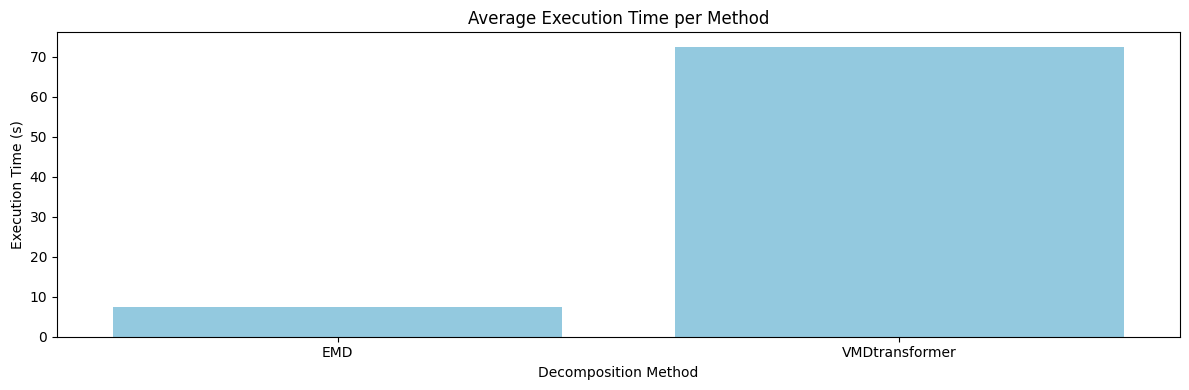

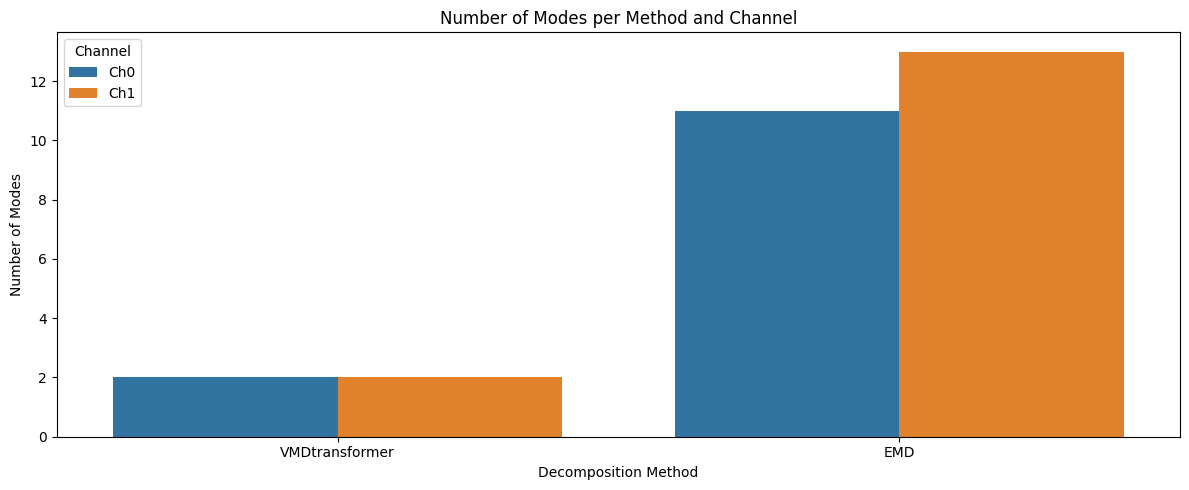

In [22]:
# Adjust the path if needed
csv_root = 'features_output'

# Plot execution times (assumes files like features_output/VMD/channel_0.csv, etc.)
plot_summary_metrics(csv_root)

# Plot feature distributions across modes and methods
#plot_feature_distributions(csv_root)


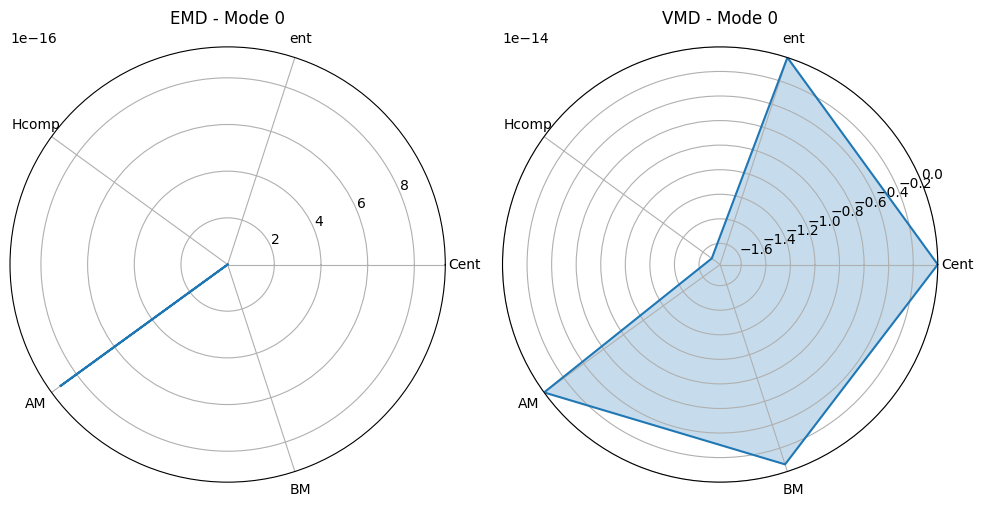

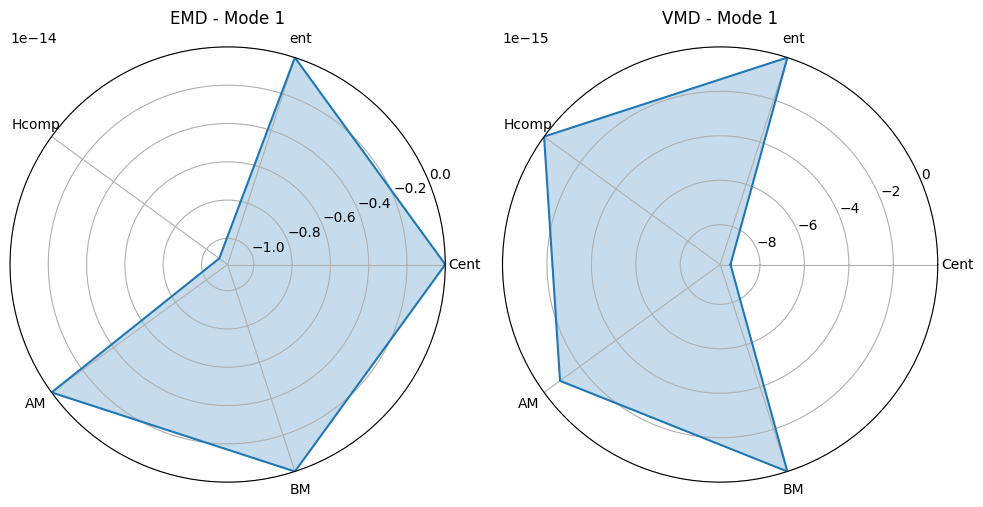

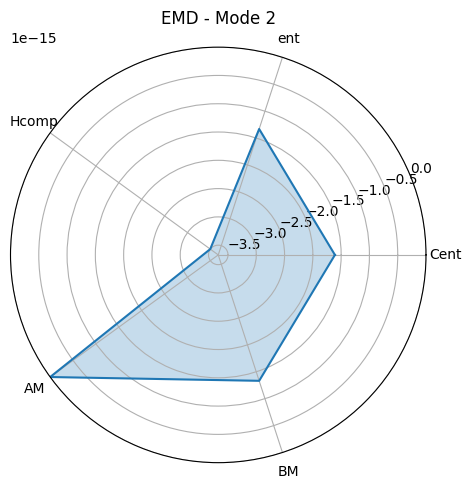

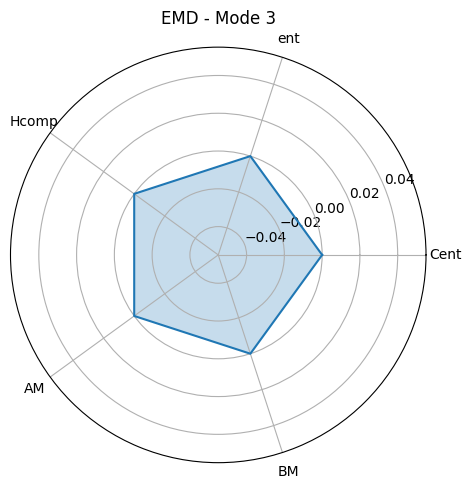

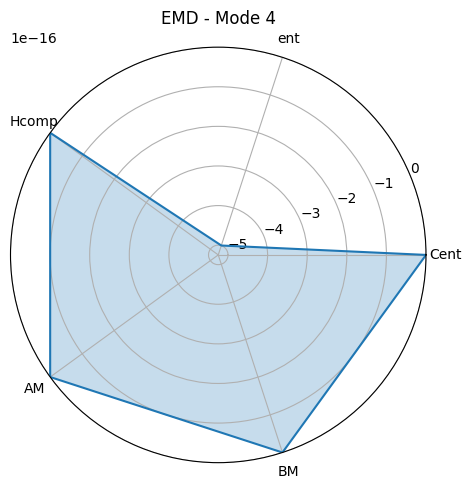

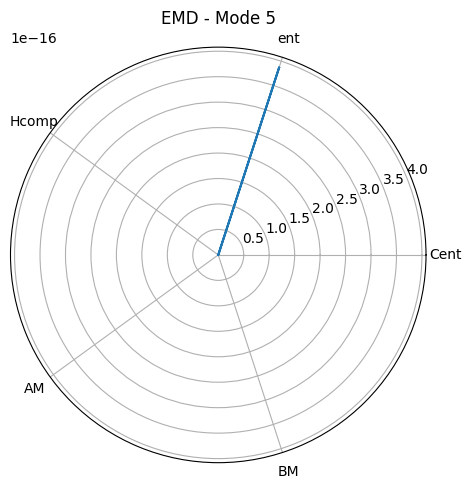

In [23]:
method_paths_dict = {
    "EMD": "features_output/EMD",
    "VMD": "features_output/VMDtransformer"
}
metrics_to_plot =  ["Cent", "ent", "Hcomp","AM","BM"]
plot_dual_or_single_radar(method_paths_dict, metrics_to_plot, max_mode_index=5)

## 1. MFA On original signal

In [99]:
# Define scaling range (you may want to try others like [7,12], [6,10], etc.)
scaling_ranges = [[6, 11]]
q_vals = build_q_log(0.1, 5, 20)

def apply_mfa(signal, ch_label=""):
    print(f"\n🔍 Applying MFA to {ch_label} — Length: {len(signal)}")

    WT = wavelet_analysis(signal, wt_name='db3')
    WTpL = WT.get_leaders(p_exp=2)
    WTpL = WTpL.auto_integrate(scaling_ranges)
    pwt = mfa(WTpL, scaling_ranges, weighted='Nj', q=q_vals)

    # Plot ζ(q)
    plt.figure(figsize=(8, 4))
    pwt.structure.plot_scaling()
    plt.title(f"ζ(q) for {ch_label}")
    plt.grid()
    plt.show()

    # Plot cumulants
    plt.figure(figsize=(8, 4))
    pwt.cumulants.plot()
    plt.title(f"Cumulants for {ch_label}")
    plt.grid()
    plt.show()

    # Plot D(h) spectrum
    plt.figure(figsize=(8, 4))
    pwt.spectrum.plot()
    plt.title(f"D(h) Spectrum for {ch_label}")
    plt.grid()
    plt.show()

    return pwt


🔍 Applying MFA to Full Channel 0 — Length: 548240


<Figure size 800x400 with 0 Axes>

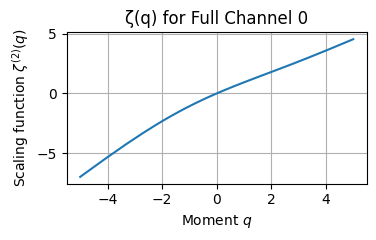

<Figure size 800x400 with 0 Axes>

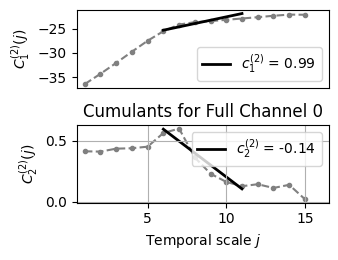

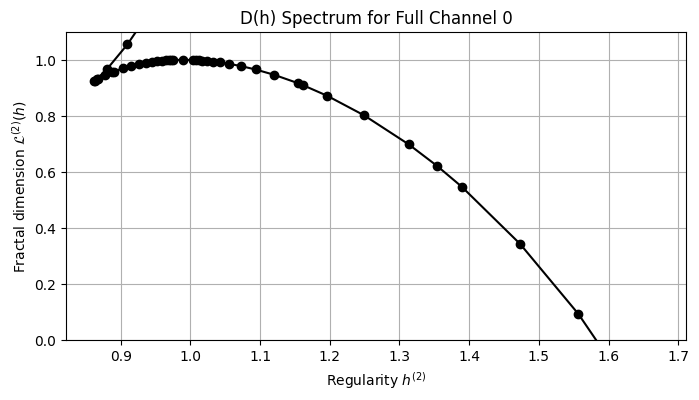


🔍 Applying MFA to Full Channel 1 — Length: 548240


<Figure size 800x400 with 0 Axes>

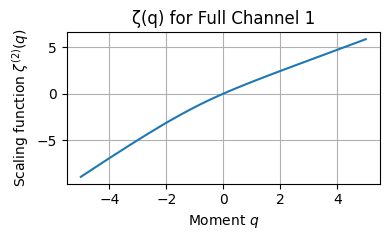

<Figure size 800x400 with 0 Axes>

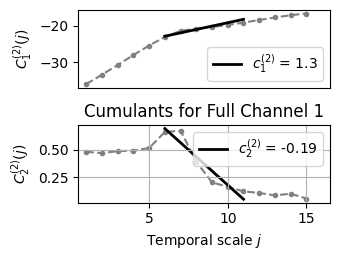

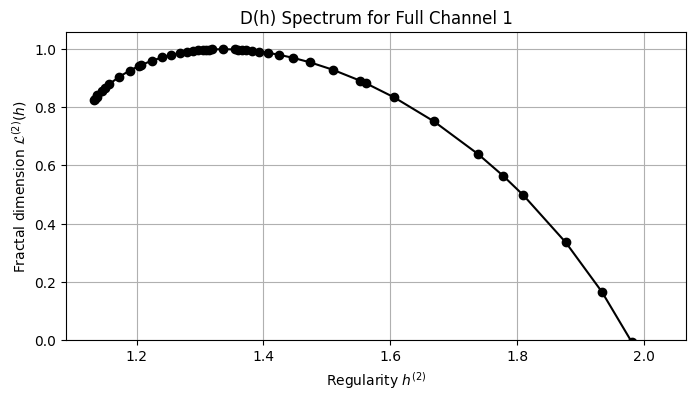

In [100]:
# Extract full signals
full_ch1 = data['data'][:, 0]
full_ch2 = data['data'][:, 1]

# Run MFA on both full channels
pwt1 = apply_mfa(full_ch1, ch_label="Full Channel 0")
pwt2 = apply_mfa(full_ch2, ch_label="Full Channel 1")

📊 Channel 1 – MFA Interpretation
1. Scaling Function ζ(q)
Smooth, concave, increasing curve

Suggests multifractality, not monofractal (a monofractal would be linear in q)

The range of q values (from ~−5 to +5) is well covered, which is good

2. Cumulants
c₁ = 0.99 → this is the average Hölder exponent:
→ ~medium regularity, possibly some long-range correlation

c₂ = −0.14 → curvature of ζ(q), linked to degree of multifractality:
→ mild multifractality (the value is small in magnitude)
→ the distribution of singularities is not very broad

3. D(h) Spectrum
Peak around h ≈ 1.0

Spectrum spans roughly from h ≈ 0.9 to h ≈ 1.6
→ Indicates some variability in regularity, but not extreme
→ Relatively narrow spectrum → suggests weak multifractality

✅ Conclusion for Channel 1:
Your MEG signal is multifractal, but only weakly. Regularities are centered around h ≈ 1.0 (similar to Brownian noise), and there is not a wide variety of singularities.

📊 Channel 2 – MFA Interpretation
1. Scaling Function ζ(q)
Also smooth and nonlinear (concave), indicating multifractality

Slightly steeper than Channel 1 → scaling is stronger at higher moments q

2. Cumulants
c₁ = 1.3 → higher than Channel 1
→ Signal is smoother on average than Channel 1

c₂ = −0.19 → slightly more negative than Channel 1
→ Slightly more multifractal than Channel 1
→ More variation in regularity, more complex structure

3. D(h) Spectrum
Peaks around h ≈ 1.3

Wider spectrum: h ≈ 1.1 to 2.0
→ Broader range of regularities
→ More singularities, richer temporal structure

✅ Conclusion for Channel 2:
This channel is more multifractal than Channel 1. The signal is smoother on average (c₁ higher) but also shows greater heterogeneity in regularity (c₂ more negative). D(h) is wider → more complex temporal behavior.



Dominant Low-Frequency Content:
The original MEG signals in both channels have most of their energy concentrated below 50 Hz, suggesting resting-state brain activity dominated by slow rhythms.

Effective Multiscale Decomposition:
EMD decomposed the signals into 10 modes (Channel 0) and 12 modes (Channel 1), progressively separating fast oscillations (early modes) from slow trends (late modes).

Noisy vs. Informative Modes:
Modes 1–3 appear noisy and high-frequency; modes 9–12 are near-flat trends. Modes 5–8 display structured, interpretable oscillations and likely capture neural dynamics.

Good Mode Separation:
The modes follow the expected EMD hierarchy — with decreasing frequency and increasing smoothness — indicating successful empirical mode decomposition.

Potential for Multifractality:
The presence of oscillatory structures across scales hints at underlying multifractal properties, especially in intermediate modes.

Justified Use of MFA on Modes:
Since different modes may capture different scaling behaviors, applying MFA separately to selected EMD modes can help isolate frequency-specific multifractal traits.


Two dominant modes only: VMD has extracted just 2 modes per channel, which suggests the algorithm likely converged early, possibly interpreting most of the frequency content as belonging to just two bands—likely due to the weak energy or narrow spectral content of the signal.

Mode 1 ≈ Original signal: In both channels, Mode 1 looks visually very similar to the original signal—VMD is capturing the main low-frequency envelope or the full-band content in this first mode. This may indicate poor separation.

Mode 2 has distinct features: Mode 2 differs in structure—particularly in Channel 0, where a drop is more sharply defined. This suggests Mode 2 is capturing localized transient or high-frequency variations, but with very low energy overall.

Limited frequency discrimination: Unlike EMD (which yielded 10–12 modes with increasing smoothness), VMD here doesn’t seem to decompose the signal into distinct frequency bands well, possibly due to low signal amplitude or suboptimal parameter tuning

## 02. VMD on the decomposed signals

In [103]:
methods=["EMD", "VMDtransformer"]

def load_modes_and_apply_mfa(base_path="saved_modes", methods= methods, n_channels=2):
    for method in methods:
        method_path = os.path.join(base_path, method)
        for ch in range(n_channels):
            file_path = os.path.join(method_path, f"channel_{ch}_modes.npy")
            if not os.path.exists(file_path):
                print(f"⚠️ Missing: {file_path}")
                continue

            modes = np.load(file_path)
            print(f"\n📂 Loaded {method} modes for Channel {ch}: shape {modes.shape}")
            for idx, mode in enumerate(modes):
                apply_mfa(mode, ch_label=f"{method} | Ch{ch} | Mode {idx}")


📂 Loaded EMD modes for Channel 0: shape (11, 548240)

🔍 Applying MFA to EMD | Ch0 | Mode 0 — Length: 548240


<Figure size 800x400 with 0 Axes>

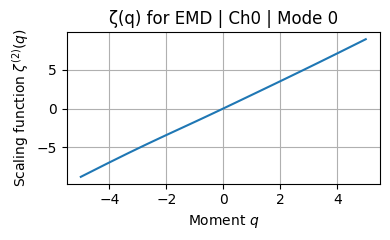

<Figure size 800x400 with 0 Axes>

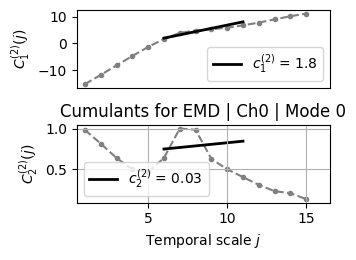

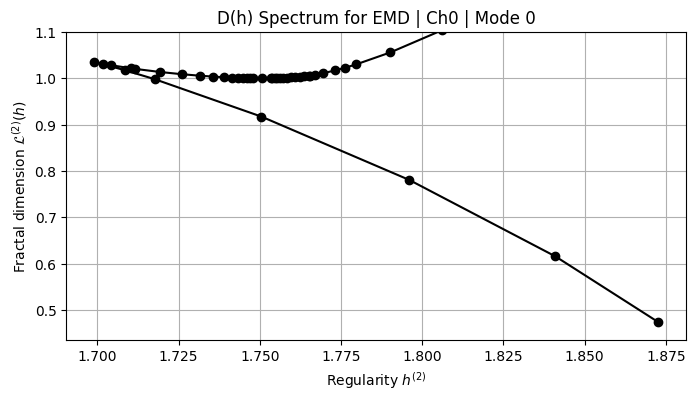


🔍 Applying MFA to EMD | Ch0 | Mode 1 — Length: 548240


<Figure size 800x400 with 0 Axes>

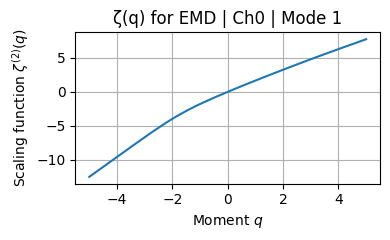

<Figure size 800x400 with 0 Axes>

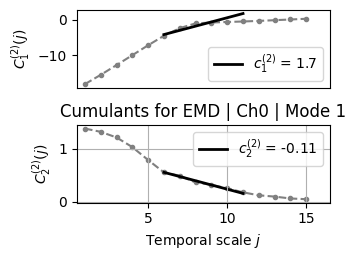

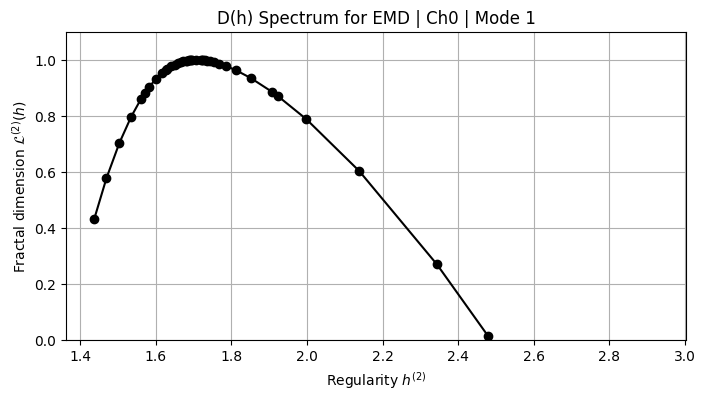


🔍 Applying MFA to EMD | Ch0 | Mode 2 — Length: 548240


<Figure size 800x400 with 0 Axes>

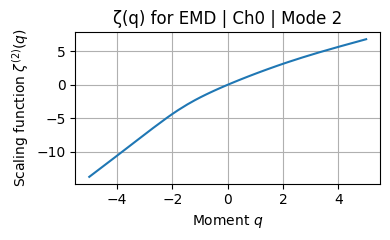

<Figure size 800x400 with 0 Axes>

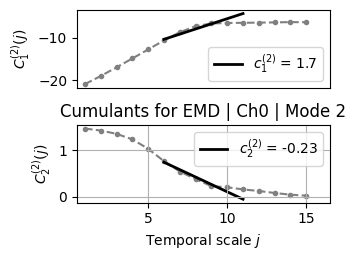

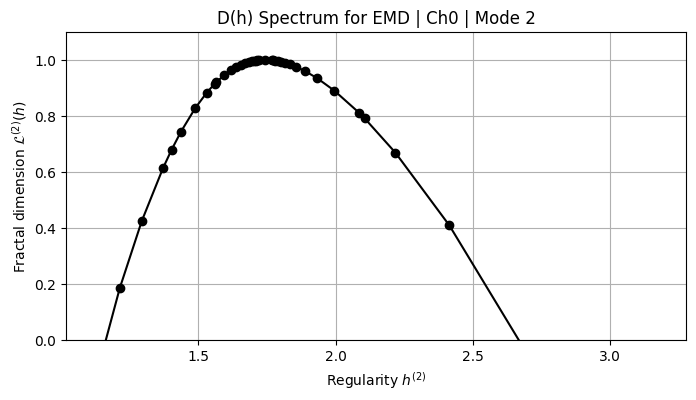


🔍 Applying MFA to EMD | Ch0 | Mode 3 — Length: 548240


<Figure size 800x400 with 0 Axes>

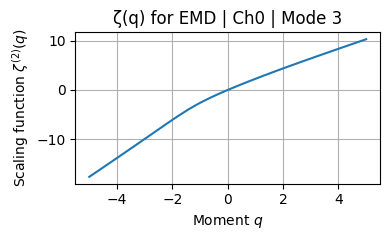

<Figure size 800x400 with 0 Axes>

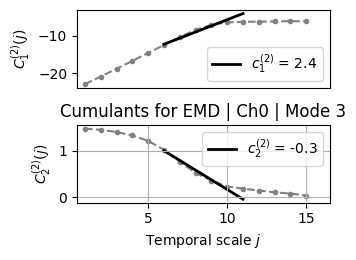

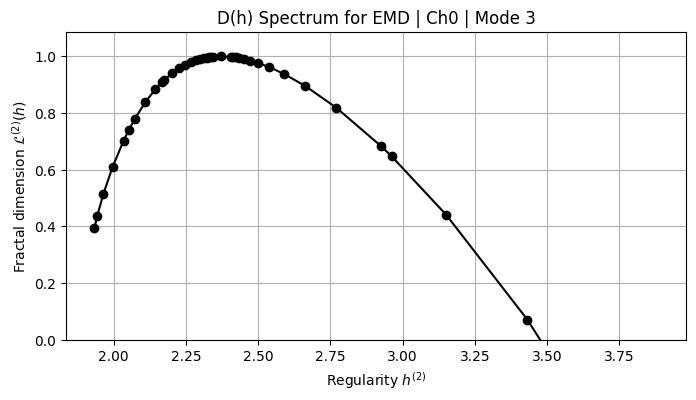


🔍 Applying MFA to EMD | Ch0 | Mode 4 — Length: 548240


<Figure size 800x400 with 0 Axes>

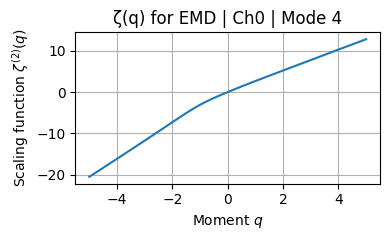

<Figure size 800x400 with 0 Axes>

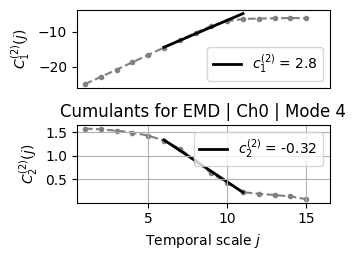

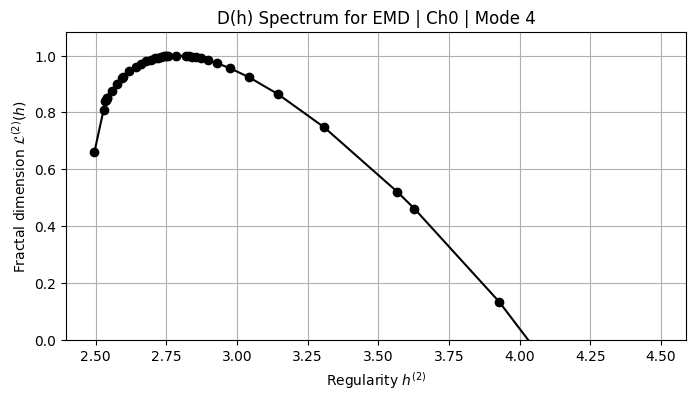


🔍 Applying MFA to EMD | Ch0 | Mode 5 — Length: 548240


<Figure size 800x400 with 0 Axes>

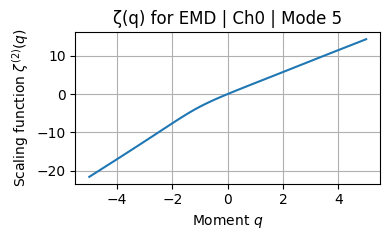

<Figure size 800x400 with 0 Axes>

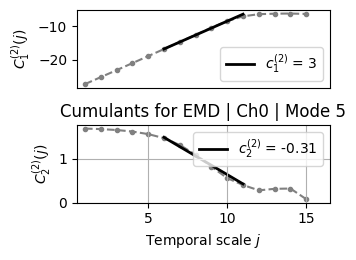

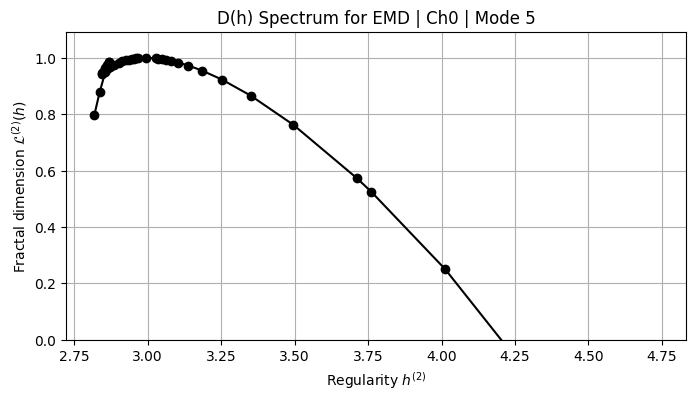


🔍 Applying MFA to EMD | Ch0 | Mode 6 — Length: 548240


<Figure size 800x400 with 0 Axes>

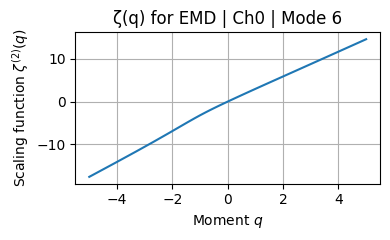

<Figure size 800x400 with 0 Axes>

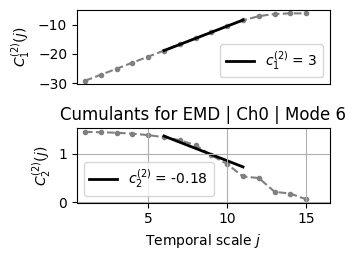

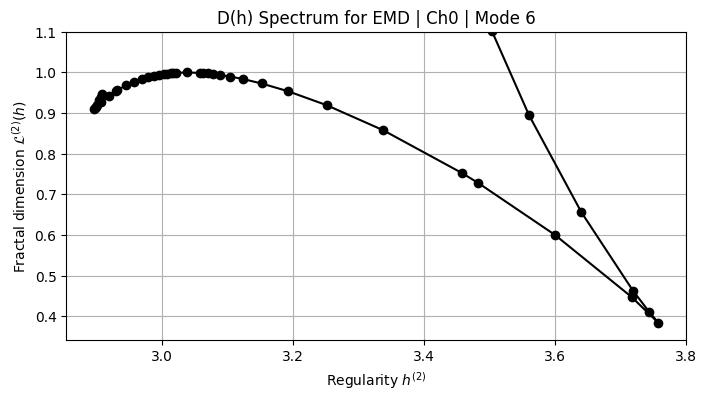


🔍 Applying MFA to EMD | Ch0 | Mode 7 — Length: 548240


<Figure size 800x400 with 0 Axes>

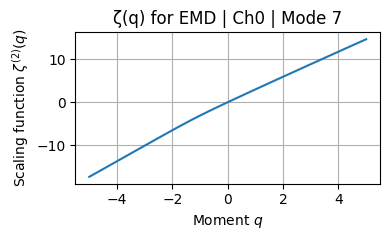

<Figure size 800x400 with 0 Axes>

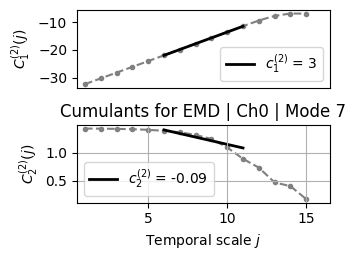

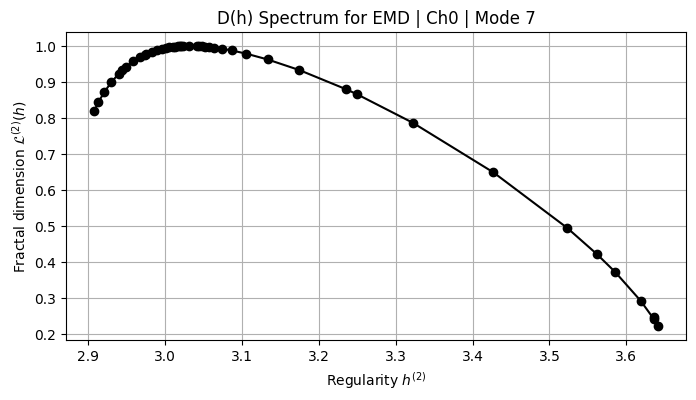


🔍 Applying MFA to EMD | Ch0 | Mode 8 — Length: 548240


<Figure size 800x400 with 0 Axes>

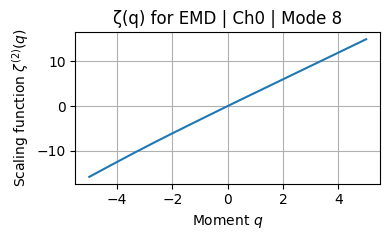

<Figure size 800x400 with 0 Axes>

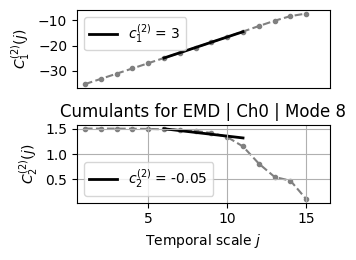

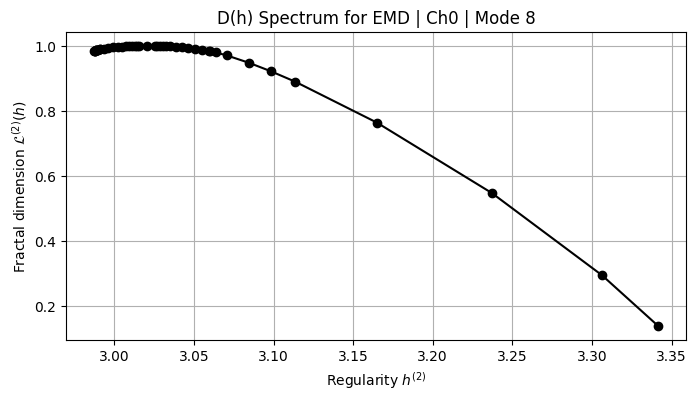


🔍 Applying MFA to EMD | Ch0 | Mode 9 — Length: 548240


<Figure size 800x400 with 0 Axes>

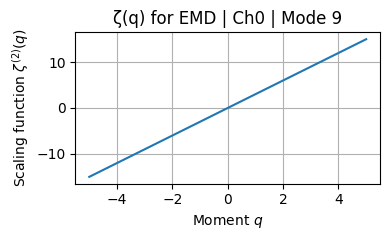

<Figure size 800x400 with 0 Axes>

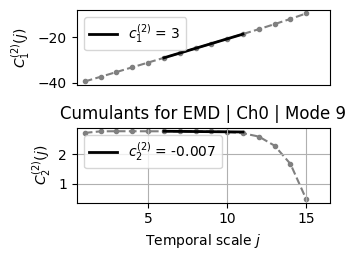

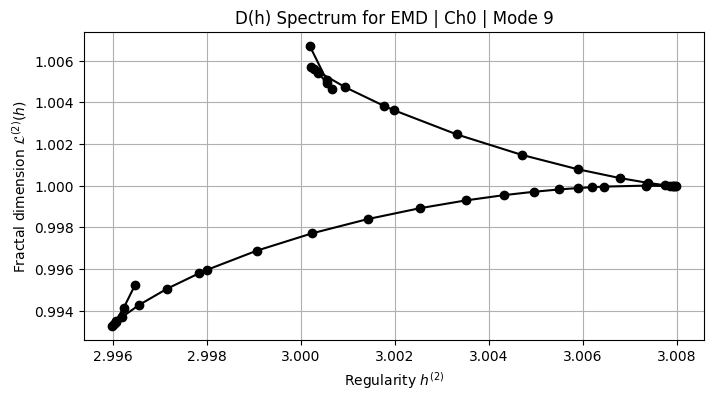


🔍 Applying MFA to EMD | Ch0 | Mode 10 — Length: 548240


<Figure size 800x400 with 0 Axes>

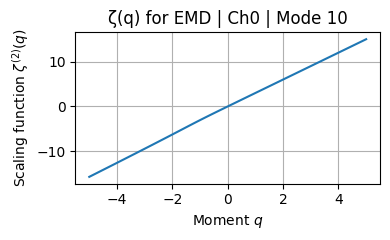

<Figure size 800x400 with 0 Axes>

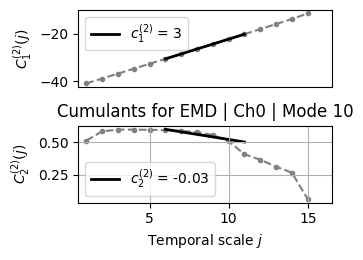

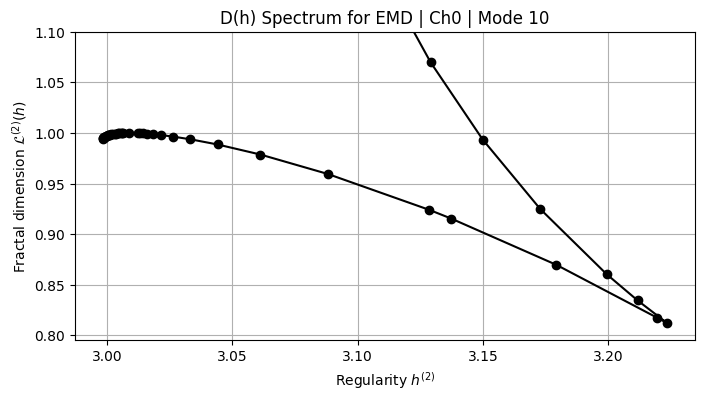


📂 Loaded EMD modes for Channel 1: shape (12, 548240)

🔍 Applying MFA to EMD | Ch1 | Mode 0 — Length: 548240


<Figure size 800x400 with 0 Axes>

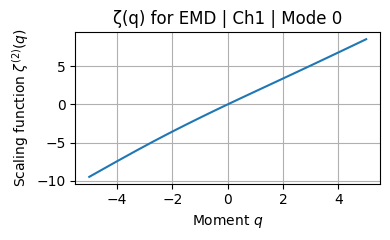

<Figure size 800x400 with 0 Axes>

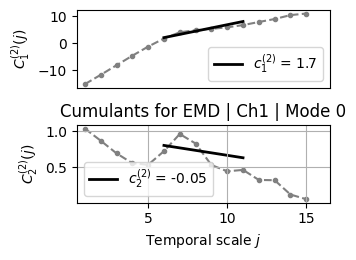

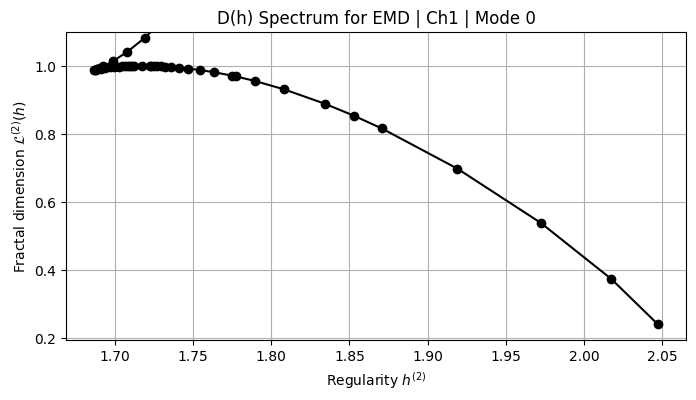


🔍 Applying MFA to EMD | Ch1 | Mode 1 — Length: 548240


<Figure size 800x400 with 0 Axes>

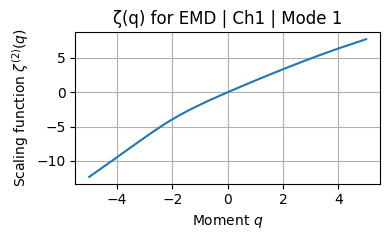

<Figure size 800x400 with 0 Axes>

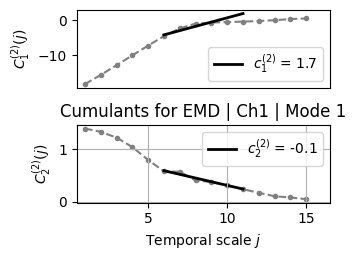

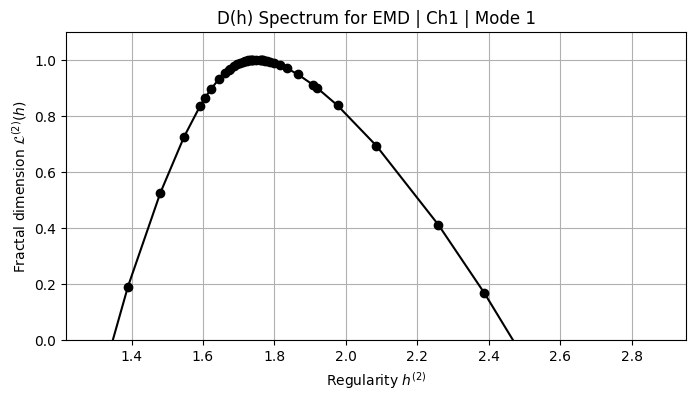


🔍 Applying MFA to EMD | Ch1 | Mode 2 — Length: 548240


<Figure size 800x400 with 0 Axes>

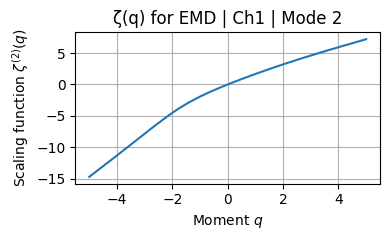

<Figure size 800x400 with 0 Axes>

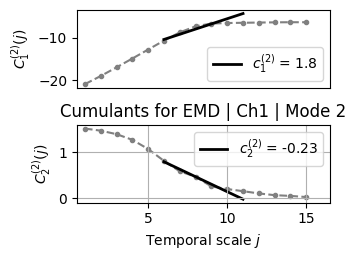

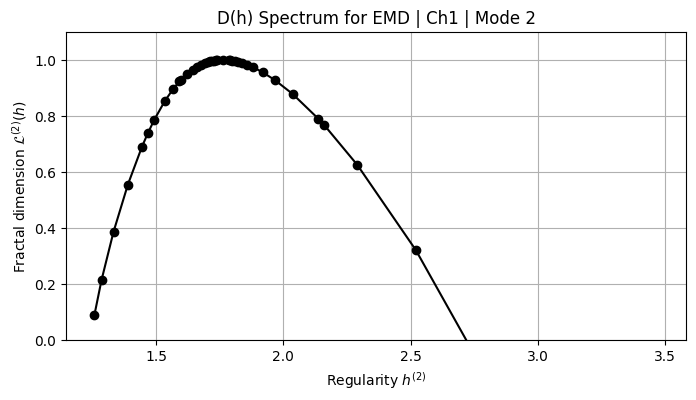


🔍 Applying MFA to EMD | Ch1 | Mode 3 — Length: 548240


<Figure size 800x400 with 0 Axes>

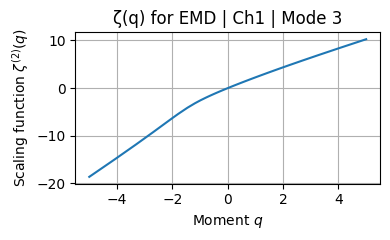

<Figure size 800x400 with 0 Axes>

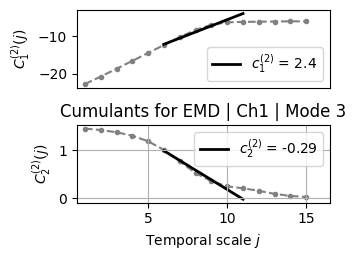

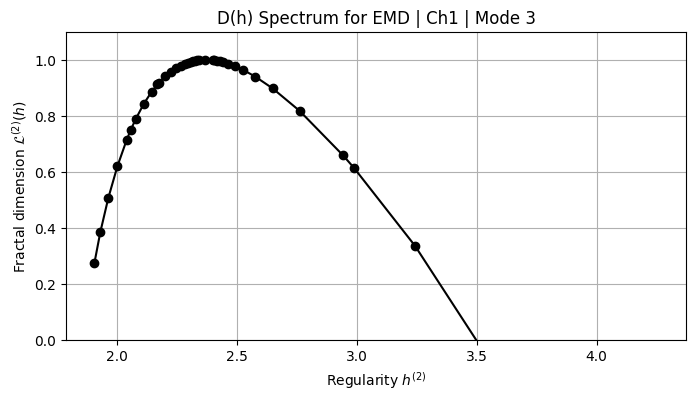


🔍 Applying MFA to EMD | Ch1 | Mode 4 — Length: 548240


<Figure size 800x400 with 0 Axes>

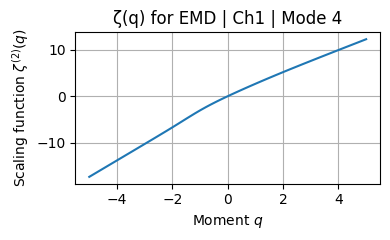

<Figure size 800x400 with 0 Axes>

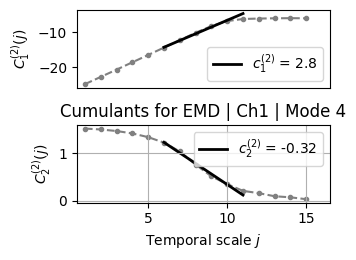

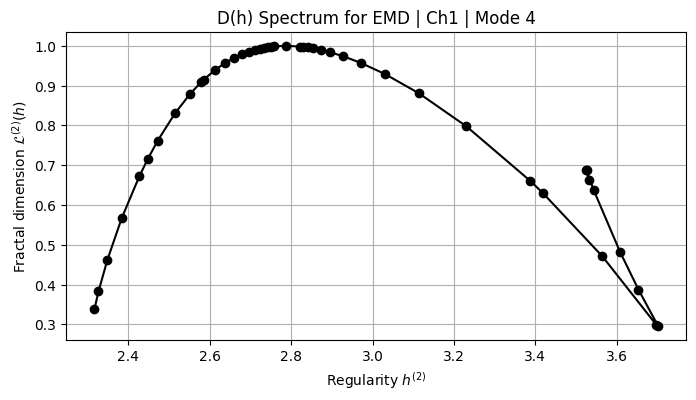


🔍 Applying MFA to EMD | Ch1 | Mode 5 — Length: 548240


<Figure size 800x400 with 0 Axes>

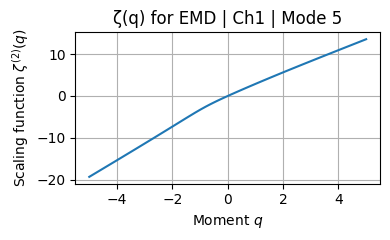

<Figure size 800x400 with 0 Axes>

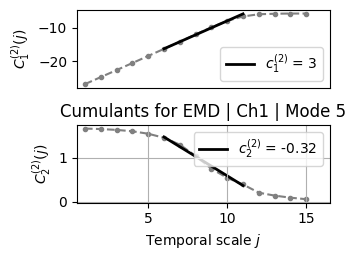

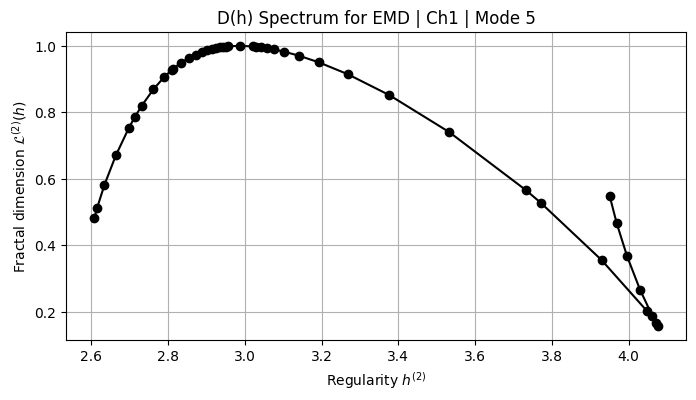


🔍 Applying MFA to EMD | Ch1 | Mode 6 — Length: 548240


<Figure size 800x400 with 0 Axes>

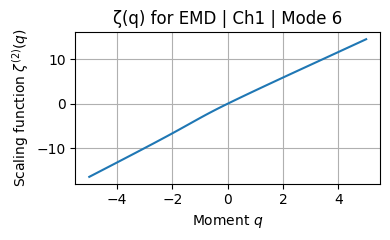

<Figure size 800x400 with 0 Axes>

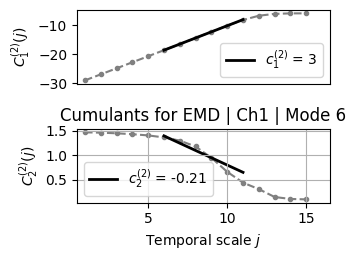

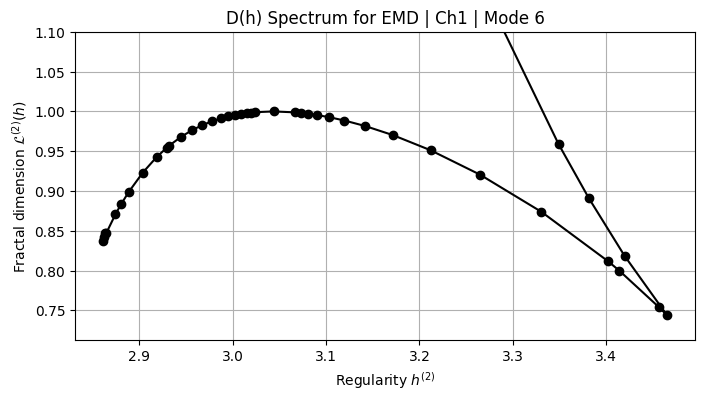


🔍 Applying MFA to EMD | Ch1 | Mode 7 — Length: 548240


<Figure size 800x400 with 0 Axes>

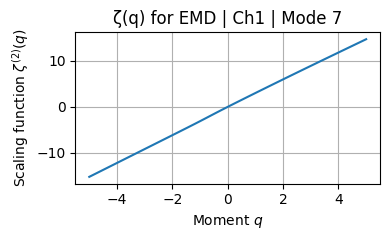

<Figure size 800x400 with 0 Axes>

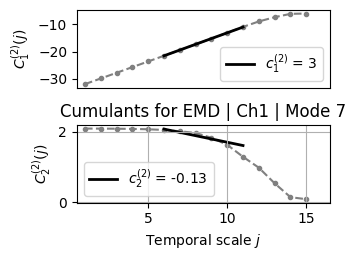

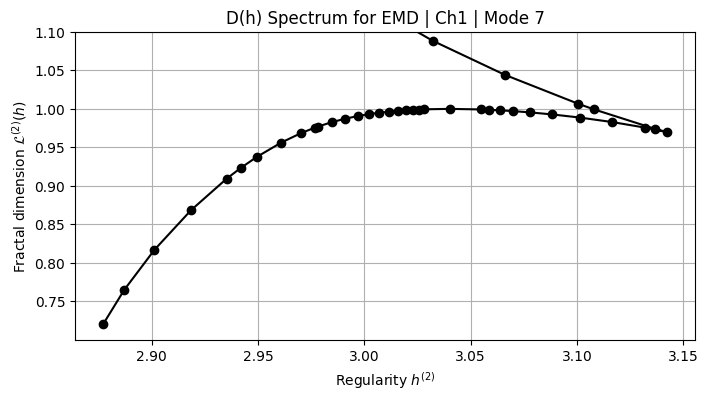


🔍 Applying MFA to EMD | Ch1 | Mode 8 — Length: 548240


<Figure size 800x400 with 0 Axes>

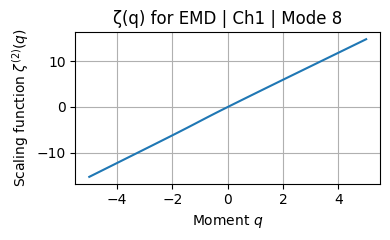

<Figure size 800x400 with 0 Axes>

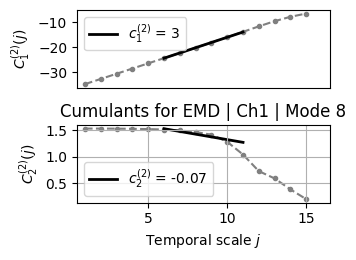

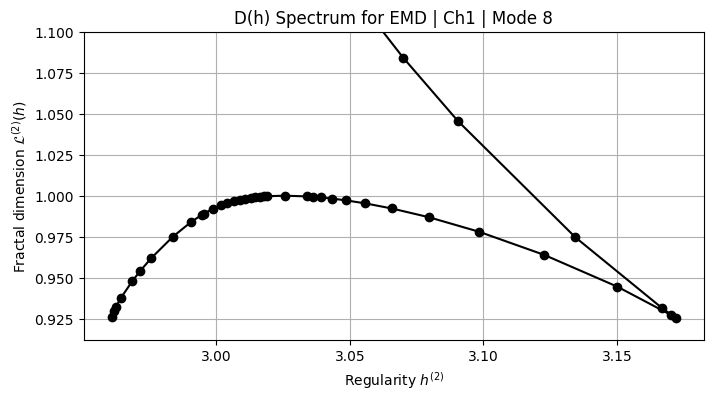


🔍 Applying MFA to EMD | Ch1 | Mode 9 — Length: 548240


<Figure size 800x400 with 0 Axes>

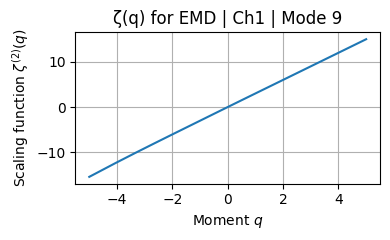

<Figure size 800x400 with 0 Axes>

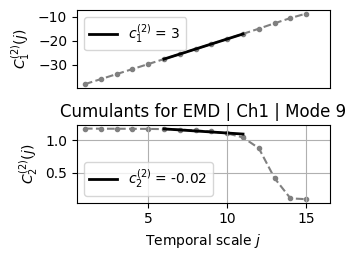

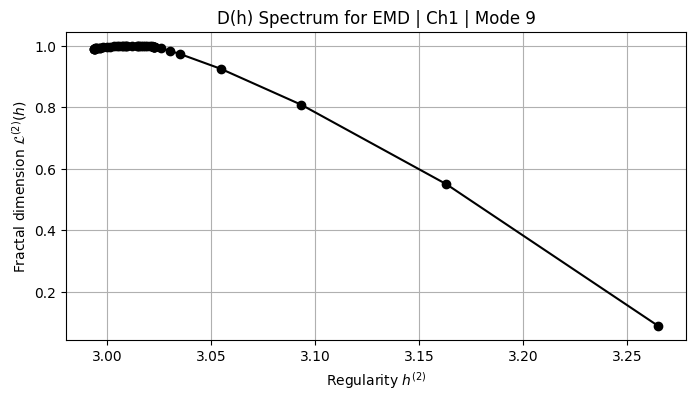


🔍 Applying MFA to EMD | Ch1 | Mode 10 — Length: 548240


<Figure size 800x400 with 0 Axes>

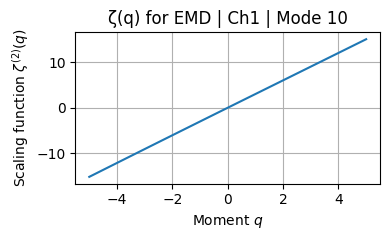

<Figure size 800x400 with 0 Axes>

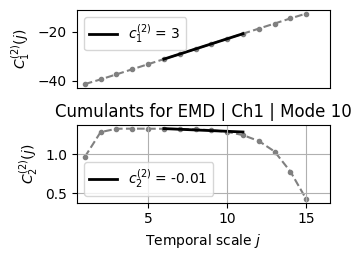

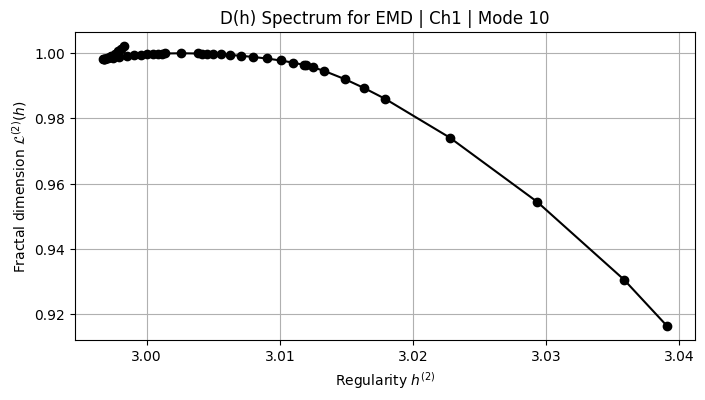


🔍 Applying MFA to EMD | Ch1 | Mode 11 — Length: 548240


<Figure size 800x400 with 0 Axes>

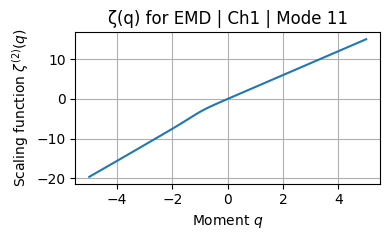

<Figure size 800x400 with 0 Axes>

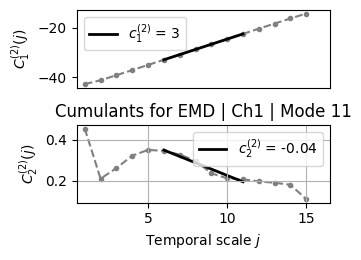

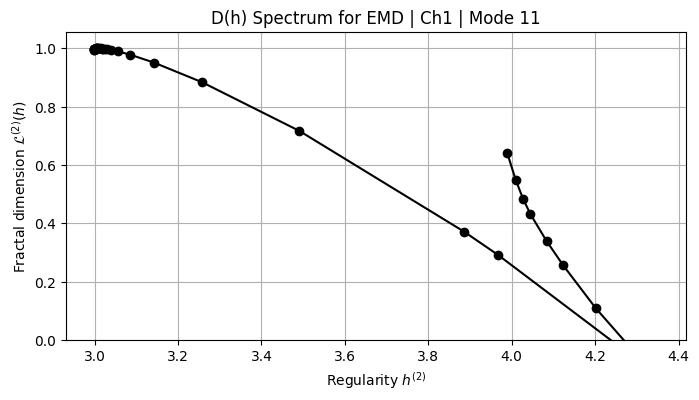


📂 Loaded VMDtransformer modes for Channel 0: shape (2, 548240)

🔍 Applying MFA to VMDtransformer | Ch0 | Mode 0 — Length: 548240


<Figure size 800x400 with 0 Axes>

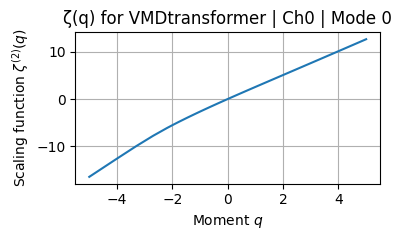

<Figure size 800x400 with 0 Axes>

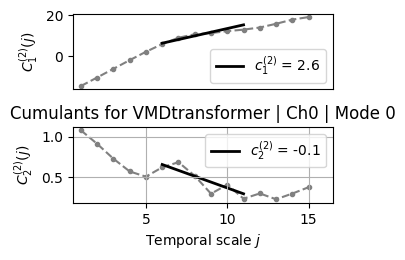

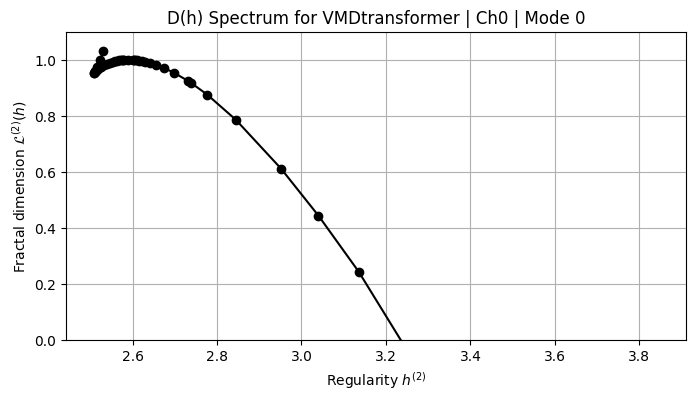


🔍 Applying MFA to VMDtransformer | Ch0 | Mode 1 — Length: 548240


<Figure size 800x400 with 0 Axes>

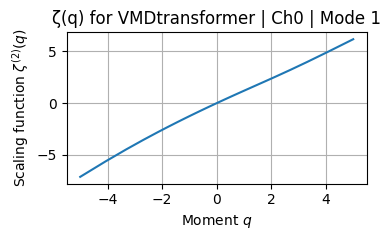

<Figure size 800x400 with 0 Axes>

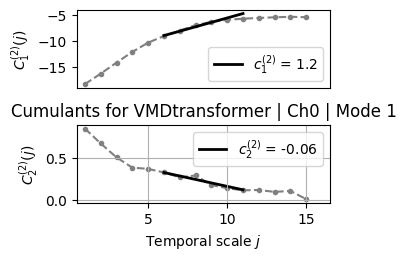

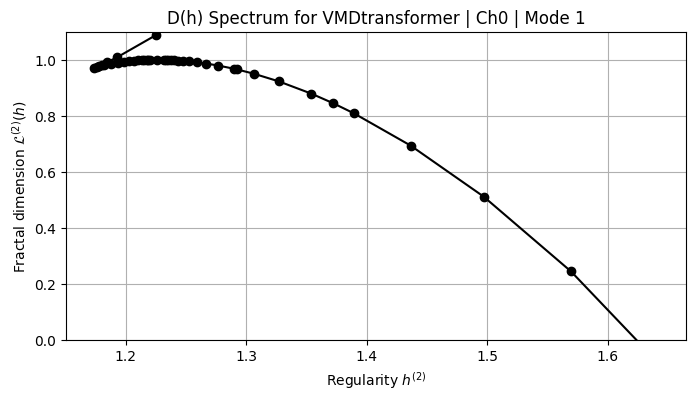


📂 Loaded VMDtransformer modes for Channel 1: shape (2, 548240)

🔍 Applying MFA to VMDtransformer | Ch1 | Mode 0 — Length: 548240


<Figure size 800x400 with 0 Axes>

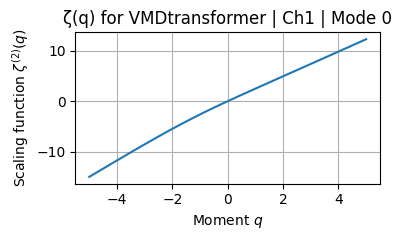

<Figure size 800x400 with 0 Axes>

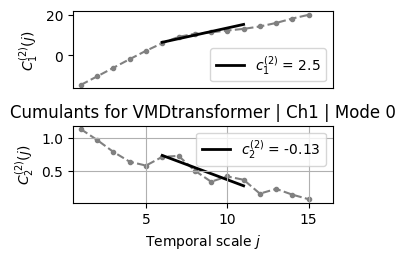

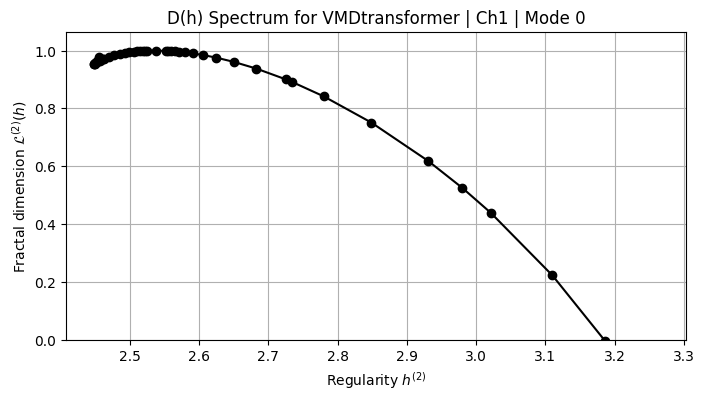


🔍 Applying MFA to VMDtransformer | Ch1 | Mode 1 — Length: 548240


<Figure size 800x400 with 0 Axes>

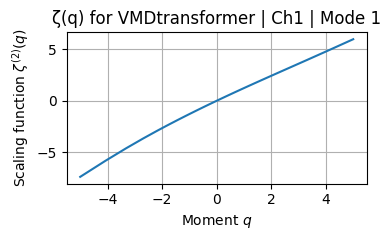

<Figure size 800x400 with 0 Axes>

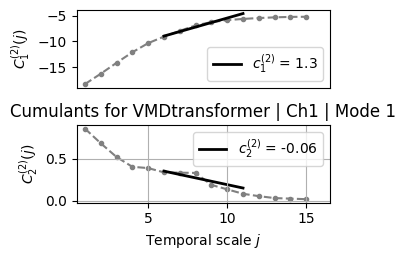

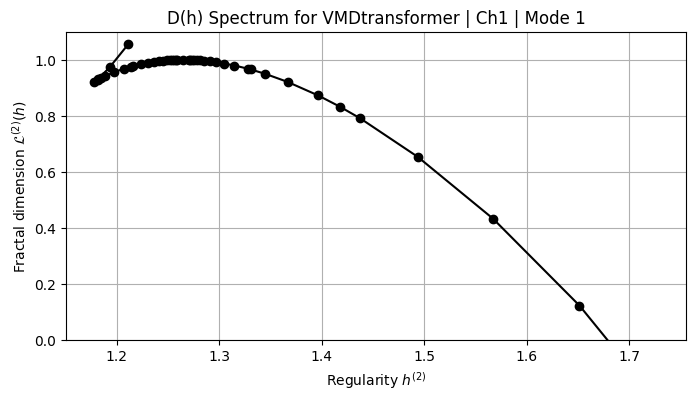

In [ ]:
load_modes_andiu_apply_mfa(base_path="saved_modes", methods=["EMD", "VMDtransformer"], n_channels=2)